### 이번 과제는 발표자 님께서 만들어주신 base form을 바탕으로 진행했습니다. 초반의 내용은 비슷하나 전처리부터 조금씩 다른 내용이 나올 예정입니다.

필요한 package들을 불러오고 분석에 사용할 데이터를 불러온다. train 데이터와 test 데이터의 차이는 target값이 없다는 것이다.

In [22]:
# ready
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# visualization
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
%matplotlib inline

In [164]:
!pip install xgboost

## 1. EDA & Data Processing


In [23]:
# Load Data
train = pd.read_csv('ggstore_train.csv')
test = pd.read_csv('ggstore_test.csv')

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5616 entries, 0 to 5615
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             5616 non-null   object 
 1   Category        5616 non-null   object 
 2   Rating          5616 non-null   float64
 3   Reviews         5616 non-null   int64  
 4   Size            5616 non-null   float64
 5   Installs        5616 non-null   float64
 6   Type            5616 non-null   int64  
 7   Price           5616 non-null   float64
 8   Content Rating  5616 non-null   object 
 9   Genres          5616 non-null   object 
 10  Last Updated    5616 non-null   object 
 11  Id              5616 non-null   int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 526.6+ KB


In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404 entries, 0 to 1403
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             1404 non-null   object 
 1   Category        1404 non-null   object 
 2   Reviews         1404 non-null   int64  
 3   Size            1404 non-null   float64
 4   Installs        1404 non-null   float64
 5   Type            1404 non-null   int64  
 6   Price           1404 non-null   float64
 7   Content Rating  1404 non-null   object 
 8   Genres          1404 non-null   object 
 9   Last Updated    1404 non-null   object 
 10  Id              1404 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 120.8+ KB


#### 연속형 변수

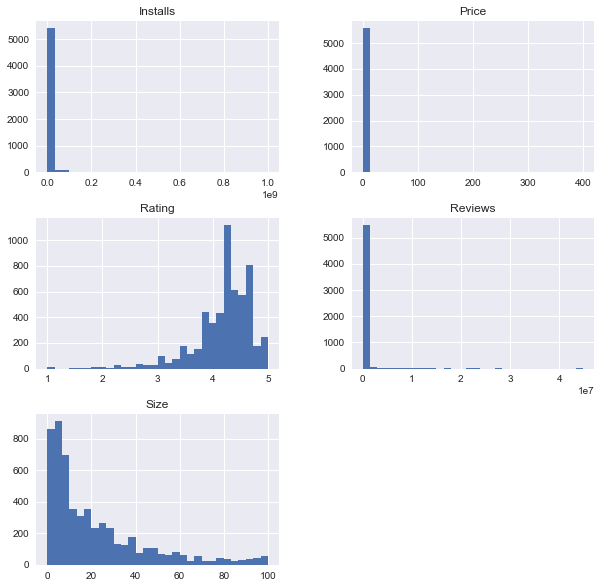

In [26]:
# 연속형 변수 분포 확인
continuous = train[['Rating','Reviews','Size','Installs','Price']]
continuous.hist(bins=30,figsize=(10,10))
plt.show()

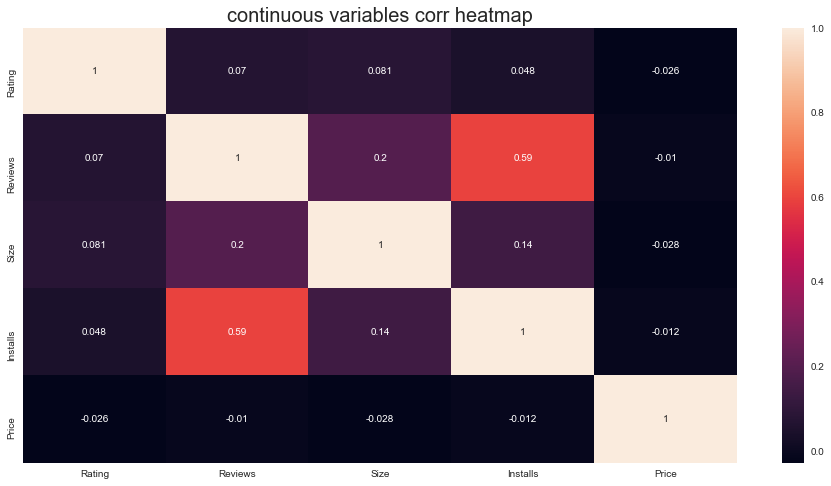

In [27]:
# 연속형 변수 heatmap 상관관계 시각화
plt.figure(figsize=(16,8))
sns.heatmap(continuous.corr(), annot=True)
plt.title('continuous variables corr heatmap', fontsize=20)

plt.show()

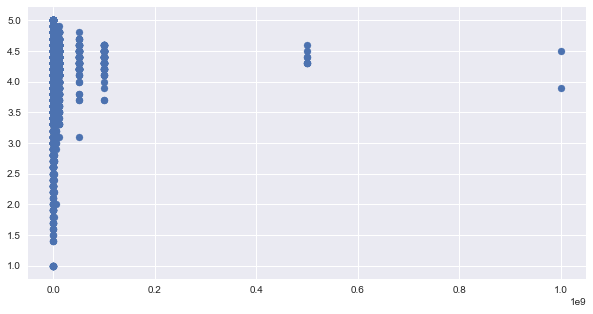

In [28]:
# Installs
plt.figure(figsize=(10,5))
plt.scatter(x = continuous['Installs'], y = continuous['Rating'])

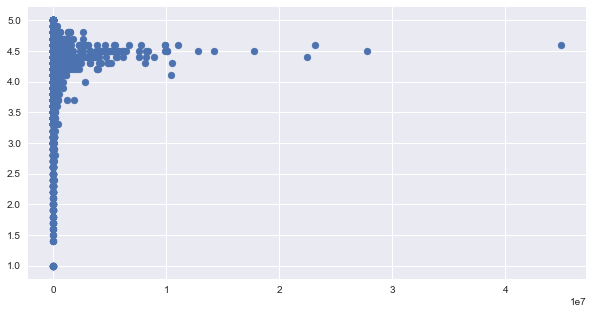

In [29]:
# Reviews
plt.figure(figsize=(10,5))
plt.scatter(x = continuous['Reviews'], y = continuous['Rating'])

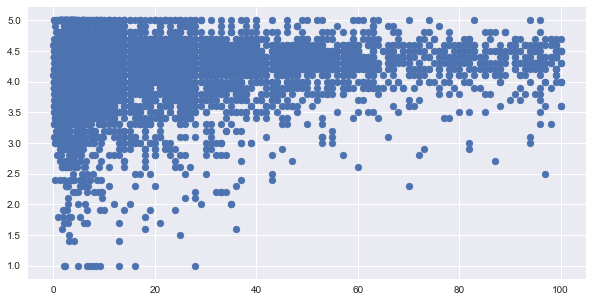

In [30]:
# Size
plt.figure(figsize=(10,5))
plt.scatter(x = continuous['Size'], y = continuous['Rating'])

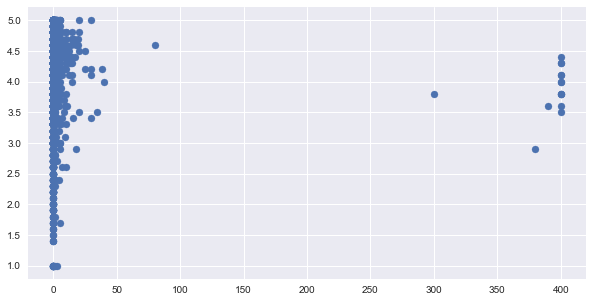

In [31]:
# Price
plt.figure(figsize=(10,5))
plt.scatter(x = continuous['Price'], y = continuous['Rating'])

#### IQR 기준으로 완전 이상한거 몇개만 제거 해 봅시다

In [32]:
def remove_outlier(df,col):
  data = df[col]
  q25 = np.percentile(data.values,25)
  q75 = np.percentile(data.values,75)

  IQR = q75 - q25
  IQR = IQR * 1.5
  low = q25-IQR ; high = q75+IQR
  outlier_index = data[(data<low)|(data>high)].index
  #print(len(outlier_index))
  #df.drop(outlier_index, axis=0, inplace=True)
  #print(df.shape)
  #return df
  return len(outlier_index)

In [33]:
print(remove_outlier(continuous,'Installs'))
print(remove_outlier(continuous,'Reviews'))
print(remove_outlier(continuous,'Price'))

1162
924
441


* 직관적으로 극단적인 이상치 몇 개만을 제거하고 새로운 continuous함수를 만듭시다. 그리고 이를 바탕으로 분포를 그려봅시다

In [34]:
out_installs = continuous[continuous['Installs'] > 200000000]
out_price = continuous[continuous['Price'] > 250]
out_reviews = continuous[continuous['Reviews'] > 15000000]
print(len(out_installs))
print(len(out_price))
print(len(out_reviews))

10
15
5


In [35]:
continuous = continuous.query('Installs < 200000000 and Price < 250 and Reviews < 40000000')
continuous.shape

(5590, 5)

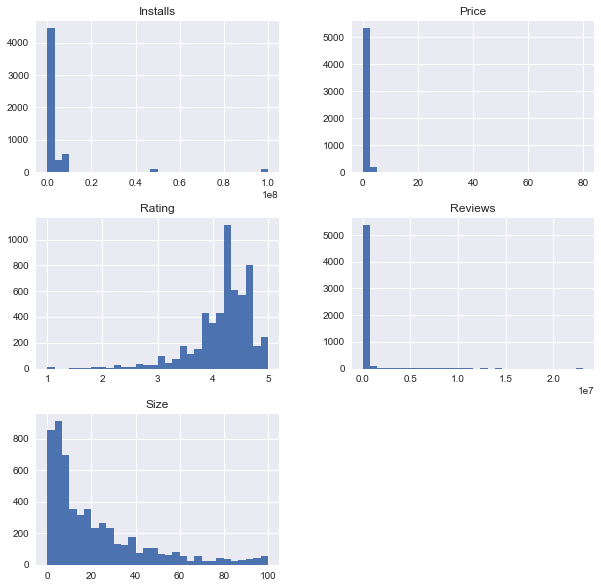

In [36]:
continuous.hist(bins=30,figsize=(10,10))
plt.show()

직관적으로 몇 개의 데이터만 삭제했음에도 불구하고 여전히 분포가 그렇게 좋아보이지 않아보일 뿐더러 이상치로 추측되는 값들도 여전히 남아있는 것 같습니다.

feature engineering을 위해 이상치를 삭제한 데이터의 그래프들을 다시 하나하나 봅니다.

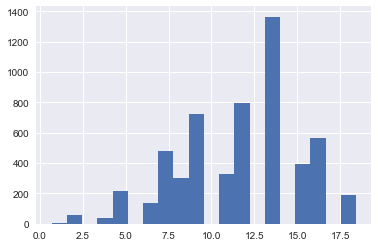

In [37]:
log_installs=np.log1p(continuous['Installs'])
log_installs.hist(bins = 20)

install 변수의 경우, 너무 왼쪽에 치우쳐저 있음이 파악됐습니다. 이를 개선하기 위해 변수에 log를 입혔습니다. 정규분포에 가깝게 퍼졌으나 중간중간 빠져 있어서 그렇게 좋아보이진 않습니다.

price, review, size도 모두 log를 취해봤습니다. 대체로 정규분포화 됐지만 price의 경우, 큰 의미가 없어보입니다. 이는 무표배포가 많기 때문일 것이라고 생각합니다. price 변수는 굳이 log scaling을 진행하지 않겠습니다.

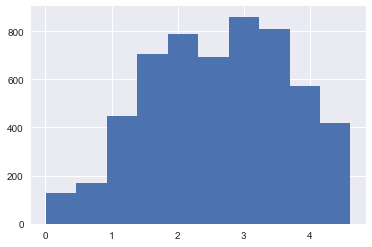

In [38]:
log_size = np.log1p(continuous['Size'])
log_size.hist()

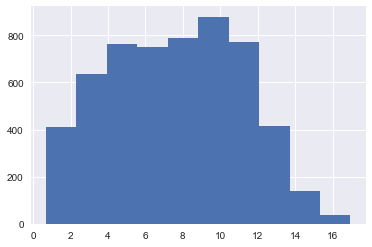

In [39]:
log_review = np.log1p(continuous['Reviews'])
log_review.hist()

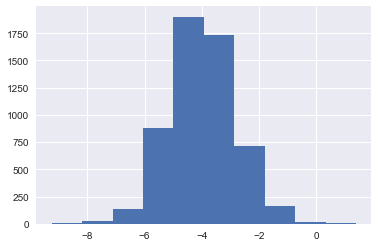

In [40]:
install_review_ratio = continuous['Reviews']/continuous['Installs']
np.log(install_review_ratio).hist()

새로운 feature인 install_review_ratio를 만들어 봤습니다. 위에 heatmap에서 install과 review가 서로 상관성이 있는 것을 바탕으로 만들었습니다. 설치한 수 당 review 수로 log scaling을 했을 때, 괜찮은 분포를 가짐을 알 수 있습니다.

구체적인 분석과 조작의 용이성을 위해 continuous2를 만들었습니다.최종적으로 만든 continuous2는 위와 같습니다.

In [43]:
continuous2 = continuous

continuous2['log_installs']=np.log1p(continuous['Installs'])
continuous2['log_size']=np.log1p(continuous['Size'])
continuous2['log_review']=np.log1p(continuous['Reviews'])
continuous2['log_install_review_ratio']=np.log1p(continuous['Reviews']/continuous['Installs'])

continuous2.drop(['Installs','Size','Reviews'],axis = 1,inplace = True)

continuous2


,Rating,Price,log_installs,log_size,log_review,log_install_review_ratio
0,4.1,0.00,9.210440,2.995732,5.075174,0.015775
1,3.9,0.00,13.122365,2.708050,6.875232,0.001932
2,4.7,0.00,15.424949,2.272126,11.379520,0.017351
3,4.5,0.00,17.727534,3.258097,12.281389,0.004304
4,4.3,0.00,11.512935,1.335001,6.875232,0.009624
...,...,...,...,...,...,...
5611,4.1,0.00,13.815512,2.041220,11.484629,0.092770
5612,4.0,0.00,13.815512,3.737670,8.416046,0.004508
5613,4.3,0.00,9.210440,1.945910,4.990433,0.014494
5614,4.5,0.00,11.512935,4.110874,8.183397,0.035174


어떤 변수를 더미변수로 만들지를 파악하기 전에 상자그림으로 과연 해당 범주형 데이터가 target에 영향을 주는지를 파악합시다.

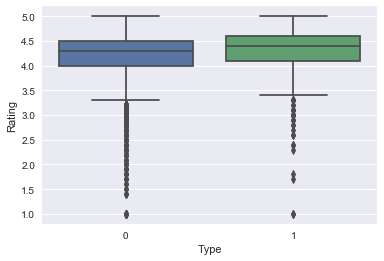

In [44]:
sns.boxplot(x=train["Type"], y=train["Rating"], data=train)
plt.show()

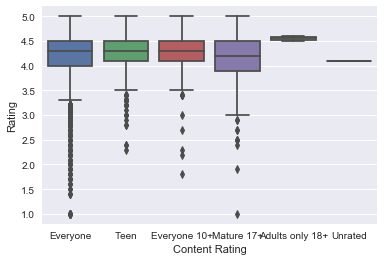

In [45]:
sns.boxplot(x=train["Content Rating"], y=train["Rating"], data=train)
plt.show()

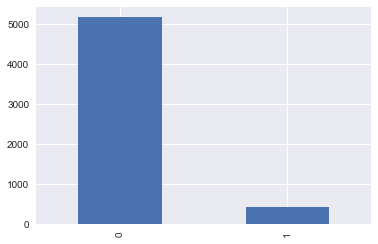

In [46]:
train["Type"].value_counts().plot(kind = 'bar')


In [47]:
category_count = train['Category'].value_counts()
category_count

FAMILY                 1102
GAME                    657
TOOLS                   463
MEDICAL                 253
PERSONALIZATION         227
LIFESTYLE               220
FINANCE                 201
PHOTOGRAPHY             175
PRODUCTIVITY            173
HEALTH_AND_FITNESS      172
BUSINESS                166
COMMUNICATION           153
SPORTS                  143
SHOPPING                139
SOCIAL                  122
DATING                  121
NEWS_AND_MAGAZINES      114
BOOKS_AND_REFERENCE     109
TRAVEL_AND_LOCAL        108
VIDEO_PLAYERS            90
EDUCATION                88
MAPS_AND_NAVIGATION      76
FOOD_AND_DRINK           69
ENTERTAINMENT            64
LIBRARIES_AND_DEMO       57
ART_AND_DESIGN           57
AUTO_AND_VEHICLES        55
HOUSE_AND_HOME           48
COMICS                   46
PARENTING                43
WEATHER                  37
EVENTS                   34
BEAUTY                   34
Name: Category, dtype: int64

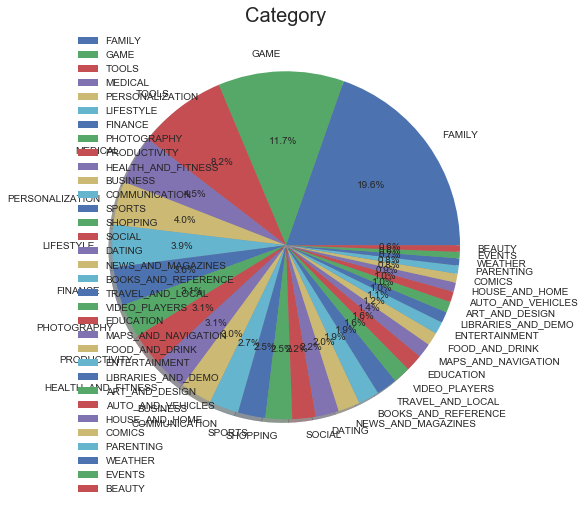

In [48]:
# Category 시각화
fig = plt.figure(figsize=(16,8)) 
plt.pie(category_count,labels=category_count.index,autopct='%1.1f%%', shadow=True)
plt.title('Category',size = 20)
plt.legend()
plt.show()

In [49]:
con_rating_count = train['Content Rating'].value_counts()
con_rating_count

Everyone           4531
Teen                589
Mature 17+          281
Everyone 10+        212
Adults only 18+       2
Unrated               1
Name: Content Rating, dtype: int64

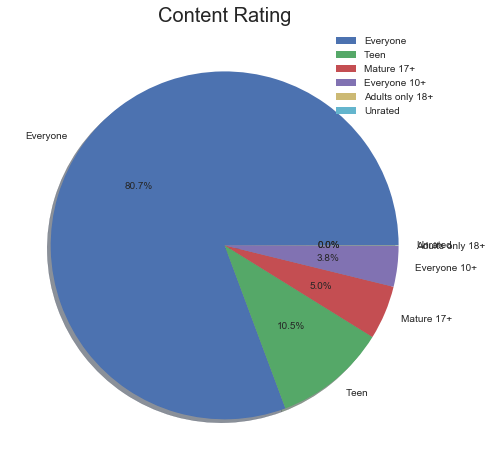

In [50]:
# Content Rating 시각화
fig = plt.figure(figsize=(16,8)) 
plt.pie(con_rating_count,labels=con_rating_count.index,autopct='%1.1f%%', shadow=True)
plt.title('Content Rating',size = 20)
plt.legend()
plt.show()

In [51]:
genres_count = train['Genres'].value_counts()
genres_count

Tools                                    463
Entertainment                            337
Education                                309
Medical                                  253
Personalization                          227
Lifestyle                                219
Action                                   214
Finance                                  201
Photography                              175
Productivity                             173
Health & Fitness                         172
Business                                 166
Communication                            153
Sports                                   149
Shopping                                 139
Arcade                                   129
Social                                   122
Dating                                   121
News & Magazines                         114
Simulation                               110
Books & Reference                        109
Travel & Local                           107
Video Play

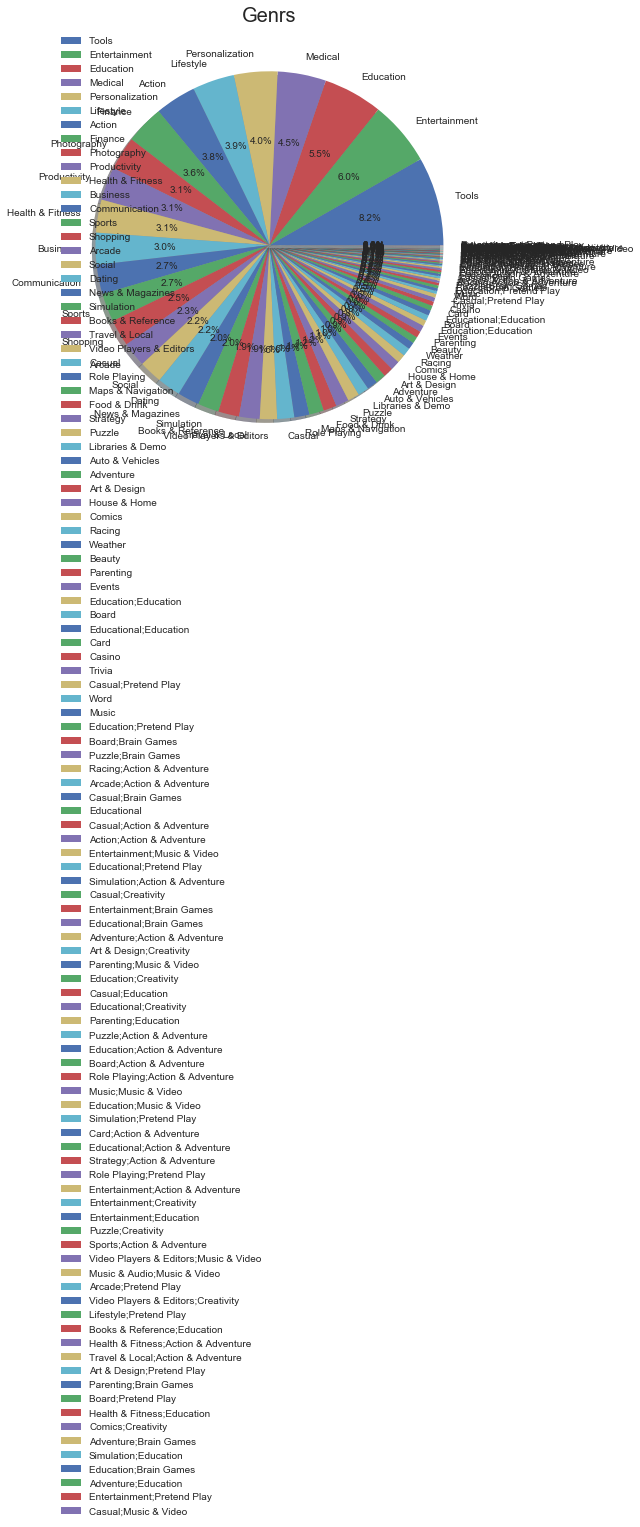

In [52]:
# Genrs 시각화
fig = plt.figure(figsize=(16,8)) 
plt.pie(genres_count,labels=genres_count.index,autopct='%1.1f%%', shadow=True)
plt.title('Genrs',size = 20)
plt.legend()
plt.show()

이와 같은 전처리를 하고 전반적인 수와 분포를 봤을 때, 개인적으로 type과 content rating이 적절해 보인다고 판단했습니다. 따라서 아래와 같이 dummy화를 진행했습니다.

In [61]:
dummies_1 = pd.get_dummies(train.Type)
dummies_2 = pd.get_dummies(train['Content Rating'])

dummies_1, dummies_2

(      0  1
 0     1  0
 1     1  0
 2     1  0
 3     1  0
 4     1  0
 ...  .. ..
 5611  1  0
 5612  1  0
 5613  1  0
 5614  1  0
 5615  0  1
 
 [5616 rows x 2 columns],
       Adults only 18+  Everyone  Everyone 10+  Mature 17+  Teen  Unrated
 0                   0         1             0           0     0        0
 1                   0         1             0           0     0        0
 2                   0         1             0           0     0        0
 3                   0         0             0           0     1        0
 4                   0         1             0           0     0        0
 ...               ...       ...           ...         ...   ...      ...
 5611                0         1             0           0     0        0
 5612                0         1             0           0     0        0
 5613                0         0             0           1     0        0
 5614                0         1             0           0     0        0
 5615         

막상 dummies를 만드니 서로 행이 안맞는 것을 파악했습니다. 행을 맞추기 위해 다시 전처리를 진행합시다.

In [62]:
train = train.query('Installs < 200000000 and Price < 250 and Reviews < 40000000')
train.shape

(5590, 12)

In [63]:
dummies_1 = pd.get_dummies(train.Type)
dummies_2 = pd.get_dummies(train['Content Rating'])

dummies_1, dummies_2

(      0  1
 0     1  0
 1     1  0
 2     1  0
 3     1  0
 4     1  0
 ...  .. ..
 5611  1  0
 5612  1  0
 5613  1  0
 5614  1  0
 5615  0  1
 
 [5590 rows x 2 columns],
       Adults only 18+  Everyone  Everyone 10+  Mature 17+  Teen  Unrated
 0                   0         1             0           0     0        0
 1                   0         1             0           0     0        0
 2                   0         1             0           0     0        0
 3                   0         0             0           0     1        0
 4                   0         1             0           0     0        0
 ...               ...       ...           ...         ...   ...      ...
 5611                0         1             0           0     0        0
 5612                0         1             0           0     0        0
 5613                0         0             0           1     0        0
 5614                0         1             0           0     0        0
 5615         

In [65]:
train2 = pd.concat([continuous2,dummies_1,dummies_2], axis = 1)
train2

,Rating,Price,log_installs,log_size,log_review,log_install_review_ratio,0,1,Adults only 18+,Everyone,Everyone 10+,Mature 17+,Teen,Unrated
0,4.1,0.00,9.210440,2.995732,5.075174,0.015775,1,0,0,1,0,0,0,0
1,3.9,0.00,13.122365,2.708050,6.875232,0.001932,1,0,0,1,0,0,0,0
2,4.7,0.00,15.424949,2.272126,11.379520,0.017351,1,0,0,1,0,0,0,0
3,4.5,0.00,17.727534,3.258097,12.281389,0.004304,1,0,0,0,0,0,1,0
4,4.3,0.00,11.512935,1.335001,6.875232,0.009624,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5611,4.1,0.00,13.815512,2.041220,11.484629,0.092770,1,0,0,1,0,0,0,0
5612,4.0,0.00,13.815512,3.737670,8.416046,0.004508,1,0,0,1,0,0,0,0
5613,4.3,0.00,9.210440,1.945910,4.990433,0.014494,1,0,0,0,0,1,0,0
5614,4.5,0.00,11.512935,4.110874,8.183397,0.035174,1,0,0,1,0,0,0,0


이 방식으로 최종적으로 만들어진 train2 데이터입니다. 이제 본격적으로 모델링을 진행합시다.

In [165]:
# sklearn 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
#from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [67]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5590 entries, 0 to 5615
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Rating                    5590 non-null   float64
 1   Price                     5590 non-null   float64
 2   log_installs              5590 non-null   float64
 3   log_size                  5590 non-null   float64
 4   log_review                5590 non-null   float64
 5   log_install_review_ratio  5590 non-null   float64
 6   0                         5590 non-null   uint8  
 7   1                         5590 non-null   uint8  
 8   Adults only 18+           5590 non-null   uint8  
 9   Everyone                  5590 non-null   uint8  
 10  Everyone 10+              5590 non-null   uint8  
 11  Mature 17+                5590 non-null   uint8  
 12  Teen                      5590 non-null   uint8  
 13  Unrated                   5590 non-null   uint8  
dtypes: float

굳이 train 데이터에서 다시 train과 test로 나누는 이유는 모델이 괜찮은지를 파악하기 위해서 입니다. test 엑셀 파일에는 y값이 없기 때문에 모델 성능 파악은 불가능합니다.이것이 train 데이터를 train과 test로 나누는 것입니다.

In [68]:
# target 분리, data split
y = train2['Rating']
X = train2.iloc[:,1:14]

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, random_state=318)

In [69]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404 entries, 0 to 1403
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             1404 non-null   object 
 1   Category        1404 non-null   object 
 2   Reviews         1404 non-null   int64  
 3   Size            1404 non-null   float64
 4   Installs        1404 non-null   float64
 5   Type            1404 non-null   int64  
 6   Price           1404 non-null   float64
 7   Content Rating  1404 non-null   object 
 8   Genres          1404 non-null   object 
 9   Last Updated    1404 non-null   object 
 10  Id              1404 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 120.8+ KB


train 데이터를 전처리 한 것과 같이 test 엑셀파일의 데이터도 마찬가리도 전처리를 진행해야합니다. 그렇지 않으면 전혀 다른 값이 나올 것입니다.

In [71]:
# Update test data

test2 = test

test2['log_installs']=np.log1p(test['Installs'])
test2['log_size']=np.log1p(test['Size'])
test2['log_review']=np.log1p(test['Reviews'])
test2['log_install_review_ratio']=np.log1p(test['Reviews']/test['Installs'])

dummies_3 = pd.get_dummies(test.Type)
dummies_4 = pd.get_dummies(test['Content Rating'])

test2 = pd.concat([test2,dummies_3,dummies_4], axis = 1)

test2.drop(['Installs','Size','Reviews','App','Category','Type','Content Rating','Genres','Last Updated'],axis = 1,inplace = True)



test_ID = test2['Id']
test2 

,Price,Id,log_installs,log_size,log_review,log_install_review_ratio,0,1,Everyone,Everyone 10+,Mature 17+,Teen
0,0.00,5617,11.512935,1.667707,7.095064,0.011978,1,0,1,0,0,0
1,0.00,5618,9.210440,0.916291,5.590987,0.026350,1,0,1,0,0,0
2,0.00,5619,9.210440,4.234107,5.214936,0.018135,1,0,1,0,0,0
3,4.99,5620,6.908755,0.788457,4.343805,0.073250,0,1,1,0,0,0
4,3.99,5621,9.210440,2.564949,6.063785,0.042005,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1399,0.00,7016,6.908755,0.481809,3.806662,0.043059,1,0,1,0,0,0
1400,0.00,7017,6.216606,1.280934,2.079442,0.013903,1,0,1,0,0,0
1401,0.00,7018,8.517393,3.988984,3.663562,0.007571,1,0,1,0,0,0
1402,0.00,7019,4.615121,1.526056,1.609438,0.039221,1,0,1,0,0,0


막상 train 데이터셋과 test 데이터셋을 비교해보니 feature의 개수가 맞지 않습니다. 아래의 과정을 통해 없는 feature를 찾아내고, test에 없는 feature를 test에 0으로 만들어 줍니다.

In [72]:
test['Content Rating'].unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+'], dtype=object)

In [74]:
# Get missing columns in the training test
missing_cols = set( train2.columns ) - set( test2.columns )
missing_cols

{'Adults only 18+', 'Rating', 'Unrated'}

In [77]:
missing_cols.remove('Rating')


KeyError: 'Rating'

In [78]:
missing_cols

{'Adults only 18+', 'Unrated'}

In [81]:
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test2[c] = 0

test2

,Price,Id,log_installs,log_size,log_review,log_install_review_ratio,0,1,Everyone,Everyone 10+,Mature 17+,Teen,Unrated,Adults only 18+
0,0.00,5617,11.512935,1.667707,7.095064,0.011978,1,0,1,0,0,0,0,0
1,0.00,5618,9.210440,0.916291,5.590987,0.026350,1,0,1,0,0,0,0,0
2,0.00,5619,9.210440,4.234107,5.214936,0.018135,1,0,1,0,0,0,0,0
3,4.99,5620,6.908755,0.788457,4.343805,0.073250,0,1,1,0,0,0,0,0
4,3.99,5621,9.210440,2.564949,6.063785,0.042005,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,0.00,7016,6.908755,0.481809,3.806662,0.043059,1,0,1,0,0,0,0,0
1400,0.00,7017,6.216606,1.280934,2.079442,0.013903,1,0,1,0,0,0,0,0
1401,0.00,7018,8.517393,3.988984,3.663562,0.007571,1,0,1,0,0,0,0,0
1402,0.00,7019,4.615121,1.526056,1.609438,0.039221,1,0,1,0,0,0,0,0


이제 서로 완벽하게 데이터 형식이 같습니다. 아래의 과정을 통해 모델링을 진행합시다.

이번 캐글 대회는 rmse값을 바탕으로 진행됩니다. 아래와 같은 함수로 rmse값을 구할 수 있는 함수를 만들어줍니다.

In [82]:
n_folds = 5
train = X
def rmse_cv(model):
  kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
  rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring='neg_mean_squared_error', cv=kf))
  return (rmse)

In [83]:
def rmse(y,y_pred):
  return np.sqrt(mean_squared_error(y,y_pred))

본격적으로 모델링을 진행합니다. scaler의 경우 robust로 진행했습니다.

In [166]:
lr = make_pipeline(RobustScaler(), LinearRegression())
dt = make_pipeline(RobustScaler(), DecisionTreeRegressor(max_depth=10))
knn = make_pipeline(RobustScaler(),KNeighborsRegressor(n_neighbors = 3))
svm = make_pipeline(RobustScaler(),SVR())
rf = make_pipeline(RandomForestRegressor())
gbm = make_pipeline(GradientBoostingRegressor(n_estimators = 3000, learning_rate=0.05,
                                              max_depth=4, max_features='sqrt',
                                              min_samples_leaf=15, min_samples_split=10,
                                              loss = 'huber', random_state=1004))
xgb_ = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
lgb_ = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=20) 

In [167]:
score = rmse_cv(lr)
print("\nLinear Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmse_cv(dt)
print("\nDecision tree score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmse_cv(knn)     
print("\nKNN score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmse_cv(svm)     
print("\nSVM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmse_cv(rf)     
print("\nRandom Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmse_cv(gbm)     
print("\nGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmse_cv(xgb_)     
print("\nXGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmse_cv(lgb_)     
print("\nLGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Linear Regression score: 0.5224 (0.0309)


Decision tree score: 0.5836 (0.0418)


KNN score: 0.5948 (0.0283)


SVM score: 0.5340 (0.0363)


Random Forest score: 0.5596 (0.0291)


GBM score: 0.5548 (0.0326)

[00:14:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:14:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:14:30] WARNING: C:\U

아무런 파라미터 설정을 진행하지 않고 값을 구하면 위와 같은 값이 나옵니다. 구체적인 값을 구하기 위해 gridsearch를 진행해봅시다.

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import rbf_kernel 

구체적인 파라미터를 잘 모르겠으면 아래와 같은 코드를 사용해 파라미터값을 확인하고 조정해줍니다.

In [110]:
grid_dt.estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'robustscaler', 'decisiontreeregressor', 'robustscaler__copy', 'robustscaler__quantile_range', 'robustscaler__with_centering', 'robustscaler__with_scaling', 'decisiontreeregressor__ccp_alpha', 'decisiontreeregressor__criterion', 'decisiontreeregressor__max_depth', 'decisiontreeregressor__max_features', 'decisiontreeregressor__max_leaf_nodes', 'decisiontreeregressor__min_impurity_decrease', 'decisiontreeregressor__min_impurity_split', 'decisiontreeregressor__min_samples_leaf', 'decisiontreeregressor__min_samples_split', 'decisiontreeregressor__min_weight_fraction_leaf', 'decisiontreeregressor__presort', 'decisiontreeregressor__random_state', 'decisiontreeregressor__splitter'])

In [109]:
param_grid_dt = {'decisiontreeregressor__max_depth':[1,2,3,4,5,6,7],
                'decisiontreeregressor__min_samples_split':[2,3],
                }

grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='neg_mean_squared_error')
grid_dt.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(max_depth=10))]),
             param_grid={'decisiontreeregressor__max_depth': [1, 2, 3, 4, 5, 6,
                                                              7],
                         'decisiontreeregressor__min_samples_split': [2, 3]},
             scoring='neg_mean_squared_error')

In [112]:
print("Best Parameter: {}".format(grid_dt.best_params_))
print("Best Cross-validity Score: {:.3f}".format(grid_dt.best_score_))
print("Test set Score: {:.3f}".format(grid_dt.score(X_test, y_test)))

Best Parameter: {'decisiontreeregressor__max_depth': 2, 'decisiontreeregressor__min_samples_split': 2}
Best Cross-validity Score: -0.276
Test set Score: -0.239


In [113]:
rmse(y_test,grid_dt.predict(X_test))

0.4891346262168141

In [114]:
param_grid_knn = {'kneighborsregressor__n_neighbors':[1,3,5,7],
                'kneighborsregressor__weights':['uniform', 'distance'],
                 'kneighborsregressor__metric' : ['euclidean', 'manhattan']}

grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='neg_mean_squared_error')
grid_knn.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor(n_neighbors=3))]),
             param_grid={'kneighborsregressor__metric': ['euclidean',
                                                         'manhattan'],
                         'kneighborsregressor__n_neighbors': [1, 3, 5, 7],
                         'kneighborsregressor__weights': ['uniform',
                                                          'distance']},
             scoring='neg_mean_squared_error')

In [151]:
print("Best Parameter: {}".format(grid_knn.best_params_))
print("Best Cross-validity Score: {:.3f}".format(grid_knn.best_score_))
print("Test set Score: {:.3f}".format(grid_knn.score(X_test, y_test)))

rmse(y_test,grid_knn.predict(X_test))

Best Parameter: {'kneighborsregressor__metric': 'euclidean', 'kneighborsregressor__n_neighbors': 7, 'kneighborsregressor__weights': 'uniform'}
Best Cross-validity Score: -0.306
Test set Score: -0.270


0.5195343677104742

In [121]:
param_grid_svm = {'svr__kernel':['linear','rbf'],
                  'svr__C':[1,5,10],
                  'svr__gamma' : ['auto', 'scale']}

grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='neg_mean_squared_error',n_jobs = -1)
grid_svm.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [1, 5, 10], 'svr__gamma': ['auto', 'scale'],
                         'svr__kernel': ['linear', 'rbf']},
             scoring='neg_mean_squared_error')

In [122]:
print("Best Parameter: {}".format(grid_svm.best_params_))
print("Best Cross-validity Score: {:.3f}".format(grid_svm.best_score_))
print("Test set Score: {:.3f}".format(grid_svm.score(X_test, y_test)))

rmse(y_test,grid_svm.predict(X_test))

Best Parameter: {'svr__C': 1, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}
Best Cross-validity Score: -0.286
Test set Score: -0.237


0.48703600897585514

In [119]:
grid_svm.estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'robustscaler', 'svr', 'robustscaler__copy', 'robustscaler__quantile_range', 'robustscaler__with_centering', 'robustscaler__with_scaling', 'svr__C', 'svr__cache_size', 'svr__coef0', 'svr__degree', 'svr__epsilon', 'svr__gamma', 'svr__kernel', 'svr__max_iter', 'svr__shrinking', 'svr__tol', 'svr__verbose'])

In [129]:
param_grid_rf = {'randomforestregressor__n_estimators':[100,200,300,400,500],
                  'randomforestregressor__max_depth':[1,2,3,4,5,6,7],
                  }

grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error',n_jobs = -1)
grid_rf.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [1, 2, 3, 4, 5, 6,
                                                              7],
                         'randomforestregressor__n_estimators': [100, 200, 300,
                                                                 400, 500]},
             scoring='neg_mean_squared_error')

In [124]:
grid_rf.estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'randomforestregressor', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomforestregressor__verbose', 'randomforestregressor__warm_start'])

In [130]:
print("Best Parameter: {}".format(grid_rf.best_params_))
print("Best Cross-validity Score: {:.3f}".format(grid_rf.best_score_))
print("Test set Score: {:.3f}".format(grid_rf.score(X_test, y_test)))

rmse(y_test,grid_rf.predict(X_test))

Best Parameter: {'randomforestregressor__max_depth': 4, 'randomforestregressor__n_estimators': 200}
Best Cross-validity Score: -0.272
Test set Score: -0.234


0.4841050783332667

In [141]:
param_grid_gbm = {'gradientboostingregressor__n_estimators':[100,250,500,750,1000,2000,3000],
                  'gradientboostingregressor__learning_rate':[0.1, 0.05, 0.01, 0.005, 0.001],
                  }

grid_gbm = GridSearchCV(gbm, param_grid_gbm, cv=5, scoring='neg_mean_squared_error')
grid_gbm.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('gradientboostingregressor',
                                        GradientBoostingRegressor(learning_rate=0.05,
                                                                  loss='huber',
                                                                  max_depth=4,
                                                                  max_features='sqrt',
                                                                  min_samples_leaf=15,
                                                                  min_samples_split=10,
                                                                  n_estimators=3000,
                                                                  random_state=1004))]),
             param_grid={'gradientboostingregressor__learning_rate': [0.1, 0.05,
                                                                      0.01,
                                                                      0.00

In [139]:
grid_gbm.estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'randomforestregressor', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomforestregressor__verbose', 'randomforestregressor__warm_start'])

In [142]:
print("Best Parameter: {}".format(grid_gbm.best_params_))
print("Best Cross-validity Score: {:.3f}".format(grid_gbm.best_score_))
print("Test set Score: {:.3f}".format(grid_gbm.score(X_test, y_test)))

rmse(y_test,grid_gbm.predict(X_test))

Best Parameter: {'gradientboostingregressor__learning_rate': 0.01, 'gradientboostingregressor__n_estimators': 500}
Best Cross-validity Score: -0.278
Test set Score: -0.232


0.4820546814285398

In [168]:
param_grid_xgb = {'xgbregressor__n_estimators':[1000,2000,3000],
                  'xgbregressor__learning_rate':[0.1, 0.01, 0.001],
                  'xgbregressor__max_depth':[3,5,7]
                  }

grid_xgb = GridSearchCV(xgb_, param_grid_xgb, cv=5, scoring='neg_mean_squared_error',n_jobs = -1)
grid_xgb.fit(X_train,y_train)

[00:23:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, xgbregressor__learning_rate, xgbregressor__max_depth, xgbregressor__n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=0.4603, gamma=0.0468,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.05, max_delta_step=None,
                                    max_depth=3, min_child_weight=1.7817,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=2200, n_j...
                                    num_parallel_tree=None, random_state=7,
                                    reg_alpha=0.464, reg_lambda=0.8571,
                                    scale_pos_weight=None, silent=1,
                                    subsample=0.5213, tree_method=None,
   

In [147]:
grid_xgb.estimator.get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity', 'silent', 'nthread'])

In [169]:
print("Best Parameter: {}".format(grid_xgb.best_params_))
print("Best Cross-validity Score: {:.3f}".format(grid_xgb.best_score_))
print("Test set Score: {:.3f}".format(grid_xgb.score(X_test, y_test)))

rmse(y_test,grid_xgb.predict(X_test))

Best Parameter: {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 1000}
Best Cross-validity Score: -0.314
Test set Score: -0.259


0.5091770877589791

In [170]:
param_grid_lgb = {'lgbmregressor__n_estimators':[10,25,50,75,100],
                  'lgbmregressor__learning_rate':[0.1, 0.05, 0.01, 0.005, 0.001],
                  'lgbmregressor__num_leaves':[10,20,30]
                  }

grid_lgb = GridSearchCV(lgb_, param_grid_lgb, cv=5, scoring='neg_mean_squared_error',n_jobs = -1)
grid_lgb.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=LGBMRegressor(learning_rate=0.05, n_estimators=20,
                                     objective='regression'),
             n_jobs=-1,
             param_grid={'lgbmregressor__learning_rate': [0.1, 0.05, 0.01,
                                                          0.005, 0.001],
                         'lgbmregressor__n_estimators': [10, 25, 50, 75, 100],
                         'lgbmregressor__num_leaves': [10, 20, 30]},
             scoring='neg_mean_squared_error')

In [171]:
print("Best Parameter: {}".format(grid_lgb.best_params_))
print("Best Cross-validity Score: {:.3f}".format(grid_lgb.best_score_))
print("Test set Score: {:.3f}".format(grid_lgb.score(X_test, y_test)))

rmse(y_test,grid_lgb.predict(X_test))

Best Parameter: {'lgbmregressor__learning_rate': 0.1, 'lgbmregressor__n_estimators': 10, 'lgbmregressor__num_leaves': 10}
Best Cross-validity Score: -0.279
Test set Score: -0.238


0.4873704255792816

In [172]:
lr = make_pipeline(RobustScaler(), LinearRegression())
dt = make_pipeline(RobustScaler(), DecisionTreeRegressor(max_depth=2, min_samples_split = 2))
knn = make_pipeline(RobustScaler(),KNeighborsRegressor(n_neighbors = 7, metric = 'euclidean',weights = 'uniform'))
svm = make_pipeline(RobustScaler(),SVR(C = 1, gamma = 'auto', kernel = 'rbf'))
rf = make_pipeline(RandomForestRegressor(max_depth = 4, n_estimators = 200))
gbm = make_pipeline(GradientBoostingRegressor(n_estimators = 500, learning_rate=0.01,
                                              max_depth=4, max_features='sqrt',
                                              min_samples_leaf=15, min_samples_split=10,
                                              loss = 'huber', random_state=1004))
xgb_ = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.1, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=1000,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
lgb_ = lgb.LGBMRegressor(objective='regression', num_leaves=10, learning_rate=0.1, n_estimators=10) 

In [179]:
from sklearn.ensemble import StackingRegressor

In [177]:
print(rmse_cv(lr).mean())
print(rmse(y_test,grid_dt.predict(X_test)))
print(rmse(y_test,grid_knn.predict(X_test)))
print(rmse(y_test,grid_svm.predict(X_test)))
print(rmse(y_test,grid_rf.predict(X_test)))
print(rmse(y_test,grid_gbm.predict(X_test)))
print(rmse(y_test,grid_xgb.predict(X_test)))
print(rmse(y_test,grid_lgb.predict(X_test)))

0.5223795963947602
0.4891346262168141
0.5195343677104742
0.48703600897585514
0.4841050783332667
0.4820546814285398
0.5091770877589791
0.4873704255792816


각 모델의 파라미터 값은 위에서 진행한 것과 같고, 최종적인 rmse는 이와 같습니다. 확실히 전반적으로 최적 파라미터를 바탕으로 진행하니 rmse값이 줄어든 것을 볼 수 있습니다.

이제 이 과제의 최종 목표인 ensemble을 진행합시다. stacking 방법은 sklearn에서 제공하는 방식을 사용하겠습니다.

In [183]:
# 파라미터 설정
estimators = [
              ('grid_gbm',gbm),
              ('grid_rf',rf),
              ('grid_svm',svm)
]
              
# Stacking
reg = StackingRegressor(
    estimators = estimators,
    final_estimator = GradientBoostingRegressor(n_estimators = 500, learning_rate=0.01,
                    max_depth=4, max_features='sqrt',min_samples_leaf=15, min_samples_split=10,
                    loss = 'huber', random_state=1004),
    cv = 5,
    n_jobs= -1,
    verbose=3
    )

# fit
reg.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('grid_gbm',
                               Pipeline(steps=[('gradientboostingregressor',
                                                GradientBoostingRegressor(learning_rate=0.01,
                                                                          loss='huber',
                                                                          max_depth=4,
                                                                          max_features='sqrt',
                                                                          min_samples_leaf=15,
                                                                          min_samples_split=10,
                                                                          n_estimators=500,
                                                                          random_state=1004))])),
                              ('grid_rf',
                               Pipeline(steps=[('randomforestregresso

In [184]:
rmse(y_test,reg.predict(X_test))

0.4854726294571488

앙상블에 기대치가 컸었는데 다이나믹하게 확 줄진 않는 모양입니다. 대략 평균정도의 값이 나온 것 같습니다. 이를 바탕으로 최종적으로 test 데이터를 예측하려고 합니다. 예측 과정은 아래와 같습니다.

In [198]:
test2 = test2.loc[:, test2.columns != 'Id']

In [199]:
test2

,Price,log_installs,log_size,log_review,log_install_review_ratio,0,1,Everyone,Everyone 10+,Mature 17+,Teen,Unrated,Adults only 18+
0,0.00,11.512935,1.667707,7.095064,0.011978,1,0,1,0,0,0,0,0
1,0.00,9.210440,0.916291,5.590987,0.026350,1,0,1,0,0,0,0,0
2,0.00,9.210440,4.234107,5.214936,0.018135,1,0,1,0,0,0,0,0
3,4.99,6.908755,0.788457,4.343805,0.073250,0,1,1,0,0,0,0,0
4,3.99,9.210440,2.564949,6.063785,0.042005,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,0.00,6.908755,0.481809,3.806662,0.043059,1,0,1,0,0,0,0,0
1400,0.00,6.216606,1.280934,2.079442,0.013903,1,0,1,0,0,0,0,0
1401,0.00,8.517393,3.988984,3.663562,0.007571,1,0,1,0,0,0,0,0
1402,0.00,4.615121,1.526056,1.609438,0.039221,1,0,1,0,0,0,0,0


In [201]:
ensemble = reg.predict(test2)

In [202]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['Rating'] = ensemble
sub.to_csv('submission.csv', index = False)

In [203]:
sub.head()

,Id,Rating
0,5617,4.122896
1,5618,4.245914
2,5619,4.117268
3,5620,4.282646
4,5621,4.367063


결과가 처참했던건 안비밀ㅠ